In [46]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import zuko
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Function for using for training emulator, based on tutorials from https://github.com/trivnguyen/nehod_torch

In [47]:
def load_file(location):
    with open(location, 'rb') as handle:
        file = pickle.load(handle)
    return file 

In [48]:
# replace this with the path to the nehod_torch repository
sys.path.append('/scratch/gpfs/el0622/nehod_torch')

import datasets
from nehod import train_utils

def norm_flows_train(hists):
    os.chdir('/scratch/gpfs/el0622/enviroment')
    name = '/scratch/gpfs/el0622/nehod_torch/data/Norm_flows_ex_hists_CDM_mw_kernel_test' #what files will be called

    data = pd.read_csv('/scratch/gpfs/jr8952/DREAMS/Parameters/CDM/MW_zooms/CDM_TNG_MW_SB5.txt',sep=" ",header=None,skiprows=1)
    data.columns = ["OM8","S8", "SN1", "SN2", "AGN"]
    SN1 = (np.array(data['SN1'].to_list()))*3.6
    SN2 = (np.array(data['SN2'].to_list()))*7.4
    AGN = (np.array(data['AGN'].to_list()))*.1

    SN1 = np.delete(SN1, (380,669), axis=0)
    SN2 = np.delete(SN2, (380,669), axis=0)
    AGN = np.delete(AGN, (380,669), axis=0)

    Rms = np.array(load_file('/scratch/gpfs/el0622/Data/Rescale/Rm_CDM_1022_fixed.txt'))
    Rms = np.delete(Rms, (380,669), axis=0)


    stellarhalomasses = load_file('/scratch/gpfs/el0622/Data/halostellarmasses.txt')
    HALO_mass = np.array(stellarhalomasses)[0]
    stellar_mass = np.array(stellarhalomasses)[1]

    SN1 = np.log10(SN1)
    SN2 = np.log10(SN2)
    AGN = np.log10(AGN)

    HALO_mass = np.log10(HALO_mass)
    stellar_mass = np.log10(stellar_mass)

    histograms = np.array(hists) 

    menclosed = load_file('/scratch/gpfs/el0622/enviroment/CDM_Data/asolar_radii_mass_FIXED.txt')
    menclosed = np.log10(menclosed)

#ALL OF THE ABOVE CAN BE MODIFIED FOR WHERE THESE ARE SAVED / WHAT QUANTITIES YOU ARE INTERESTED IN

    #convert data to NeHOD datatype
    header = 'log_sn1,log_sn2,log_agn1,log_M_halo,log_M_star,log_M_enclosed,Rm'
    for i in range(len(histograms[0])):
        header += ','+'histogram'+str(i)

    data_cond = np.zeros((1024-2,67)) 

    data_cond[:,0] = SN1
    data_cond[:,1] = SN2
    data_cond[:,2] = AGN
    data_cond[:,3] = HALO_mass
    data_cond[:,4] = stellar_mass
    data_cond[:,5] = menclosed
    data_cond[:,6] = Rms

    for i in range(0,len(histograms[0])):
        data_cond[:,i+7] = histograms[:,i]

    np.savetxt(f"{name}_cond.csv", data_cond, delimiter=',', header=header, comments='')

    #since we only care about the central, this line is useless but necessary
    np.savez(f'{name}', features=np.ones((len(data_cond),10,5)), mask=np.ones((len(data_cond),10),dtype=bool)) 

    # Define the conditioning features and target features of the flows
    conditioning_parameters = ['log_sn1','log_sn2','log_agn1','log_M_halo']

    target_parameters = ['log_M_star','log_M_enclosed','Rm']
    for i in range(len(histograms[0])):
        target_parameters.append('histogram'+str(i))

    num_target = len(target_parameters)

    # Note that `datasets.read_preprocess_dataset` is designed to read both the 
    # satellite galaxies and conditioning features, so this is a quick workaround
    _, data, _, norm_dict = datasets.read_preprocess_dataset(
        data_root='data', data_name=name, flag=None,
        conditioning_parameters=target_parameters + conditioning_parameters)
    target = data[:, :num_target]
    cond = data[:, num_target:]

    # restructuring the norm_dict
    new_norm_dict = {
        'target_mean': norm_dict['cond_mean'][:num_target],
        'target_std': norm_dict['cond_std'][:num_target],
        'cond_mean': norm_dict['cond_mean'][num_target:],
        'cond_std': norm_dict['cond_std'][num_target:],
    }

    train_data = 0.8
    valid_data = 0.1
    test_data = 0.1

    nsims = len(target)
    sim_idx = np.arange(nsims)
    np.random.shuffle(sim_idx)

    target_train = target[sim_idx][:int(nsims*train_data)]
    cond_train = cond[sim_idx][:int(nsims*train_data)]

    target_valid = target[sim_idx][int(nsims*train_data):int(nsims*train_data)+int(nsims*valid_data)]
    cond_valid = cond[sim_idx][int(nsims*train_data):int(nsims*train_data)+int(nsims*valid_data)]

    target_test = target[sim_idx][int(nsims*train_data)+int(nsims*valid_data):]
    cond_test = cond[sim_idx][int(nsims*train_data)+int(nsims*valid_data):]

    data_loader_train = datasets.create_dataloader(
        (target_train, cond_train), batch_size=32,
        shuffle=True, pin_memory=torch.cuda.is_available(),
        num_workers=4)

    data_loader_valid = datasets.create_dataloader(
        (target_valid, cond_valid), batch_size=32,
        shuffle=False, pin_memory=torch.cuda.is_available(),
        num_workers=4)

    data_loader_test = datasets.create_dataloader(
        (target_test, cond_test), batch_size=32,
        shuffle=False, pin_memory=torch.cuda.is_available(),
        num_workers=4)

    class NPE(pl.LightningModule):
        def __init__(self, norm_dict=None):
            super().__init__()
            # Lightning allows extra information to be saved in with the model
            # this is a convenient way to save the normalization statistics
            self.norm_dict = norm_dict
            self.save_hyperparameters()

            # hyperparameters of the flows as defined in `configs/example_flows.py`
            context_dim = len(conditioning_parameters)
            in_dim = len(target_parameters)
            num_transforms = 4
            projection_dims = [32, 32]
            hidden_dims = [16, 16, 16, 16]
            dropout = 0.1

            self.lin_proj_layers = nn.ModuleList()
            for i in range(len(projection_dims)):
                in_proj_dim = context_dim if i == 0 else projection_dims[i - 1]
                out_proj_dim = projection_dims[i]
                self.lin_proj_layers.append(nn.Linear(in_proj_dim, out_proj_dim))
                self.lin_proj_layers.append(nn.ReLU())
                self.lin_proj_layers.append(nn.BatchNorm1d(out_proj_dim))
                self.lin_proj_layers.append(nn.Dropout(dropout))
            self.lin_proj_layers = nn.Sequential(*self.lin_proj_layers)
            self.flow = zuko.flows.NSF(
                in_dim, projection_dims[-1], transforms=num_transforms,
                hidden_features=hidden_dims, randperm=True
            )

        def forward(self, context):
            embed_context = self.lin_proj_layers(context)
            return embed_context

        def training_step(self, batch, batch_idx):
            target, context = batch
            embed_context = self.forward(context)
            loss = -self.flow(embed_context).log_prob(target).mean()
            self.log('train_loss', loss, on_step=True, on_epoch=True, batch_size=target.size(0))
            return loss

        def validation_step(self, batch, batch_idx):
            target, context = batch
            embed_context = self.forward(context)
            loss = -self.flow(embed_context).log_prob(target).mean()
            self.log('val_loss', loss, on_step=True, on_epoch=True, batch_size=target.size(0))
            return loss

        def configure_optimizers(self):
            optimizer = optim.AdamW(
                self.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=0.01)
            return optimizer
        
    pl.seed_everything(1234)

    # Initialize the model
    model = NPE(norm_dict=new_norm_dict)

    # Define callbacks function, including early stopping, model checkpointing, and learning rate monitoring
    callbacks = [
        pl.callbacks.ModelCheckpoint(
            filename="{epoch}-{val_loss:.4f}", monitor='val_loss',
            save_top_k=1, mode='min', save_weights_only=False,
            save_last=True),
    ]
    # logger to save the training logs, this should work even if you don't have tensorboard installed
    # alternatively, you can use pl_loggers.WandbLogger to log the results to Weights & Biases
    # or pl_loggers.CSVLogger to save the logs to a CSV file
    # train_logger = pl_loggers.TensorBoardLogger('output/flows', version='')
    train_logger = pl_loggers.CSVLogger('output/flows', version='')

    # Define a PyTorch Lightning Trainer, which will handle the entire training process
    trainer = pl.Trainer(
        default_root_dir='output/flows',
        max_steps=5_000,  # maximum number of training steps   
        accelerator='cpu',  # remove if running on CPU
        callbacks=callbacks,
        logger=train_logger,
        enable_progress_bar=False,
        inference_mode=False,
        val_check_interval=20,
        check_val_every_n_epoch=None,
        log_every_n_steps=10,
    )

    # train the model
    trainer.fit(
        model, train_dataloaders=data_loader_train, val_dataloaders=data_loader_valid, 
        ckpt_path=None)  # add ckpt_path to resume training

    data = pd.read_csv('output/flows/lightning_logs/metrics.csv',sep=",",header=None,skiprows=1)
    data.columns = ["epoch", "step", "training_loss_epoch", "training_loss_step","val_loss_epoch","val_loss_step"]

    return model,new_norm_dict



# Function for using emulator to sample, based on tutorials from https://github.com/trivnguyen/nehod_torch

In [67]:
#RUN EMULATOR
def norm_flows_sample(model,new_norm_dict,num_samples):

    pl.seed_everything(1234)
    n_samples = num_samples  # number of samples to generate
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Sample new conditioning features (or context) from the prior distribution
    context_min = np.array(
        [np.log10(0.9), np.log10(3.7), np.log10(0.025),11.6])
    context_max = np.array(
        [np.log10(14.4), np.log10(14.8), np.log10(0.4),12.2])

    context = np.random.uniform(context_min, context_max, size=(n_samples, 4))

    # halo_range = np.random.uniform(11.6,12.2,size=(n_samples,1))

    #All of the above halo mass range, sample size, etc. can be modified

    # context = np.zeros((n_samples,4))
    # for i in range((n_samples)):
    #     context[i,:] = np.array([np.log10(3.6),np.log10(7.4),np.log10(.1),halo_range[i][0]])

    # normalized and convert to tensor
    context_norm = (context - new_norm_dict['cond_mean']) / new_norm_dict['cond_std']
    context_norm = torch.tensor(context_norm, dtype=torch.float32)
    context_norm = context_norm.to(model.device)

    with torch.no_grad():
        flow_context = model(context_norm)
        samples = model.flow(flow_context).sample()
        samples = samples.cpu().numpy()

    # rescale the samples to the original scale
    samples = samples * new_norm_dict['target_std'] + new_norm_dict['target_mean']

    return samples

In [68]:
#Output of KDE, see KDE tutorial file
#load from wherever you have saved
hists = load_file('/scratch/gpfs/el0622/enviroment/CDM_Data/Histograms_Tutorial.txt')

In [70]:
#train emualtor
model_1,new_norm_dict_1 = norm_flows_train(hists)

#number of galaxies to sample
num_samps = 600

#use emulator to sample
em_hists = norm_flows_sample(model_1,new_norm_dict_1,num_samps)

[rank: 0] Seed set to 1234


# Plot the results

In [71]:
def histogram_averaging(histograms):
    c = histograms

    #calculating the maxes in each bin
    maxs = []
    mins = []
    for i in range(len(binpos)-1):
        maxs.append(np.max(c[:,i]))
        mins.append(np.min(c[:,i]))
    
    #calculating the mean in each bin and standard deviation of each bin
    median = np.percentile(c,50,axis=0)
    sixteen = np.percentile(c,16,axis=0)# c.percentile(16,axis=0)
    eightyfour = np.percentile(c,84,axis=0)
    two = np.percentile(c,2,axis=0)# c.percentile(16,axis=0)
    ninetyeight = np.percentile(c,98,axis=0)

    return median,mins,two,sixteen,eightyfour,ninetyeight,maxs

In [72]:
binpos = np.linspace(0, 650, 61)
LINEWIDTH = 3

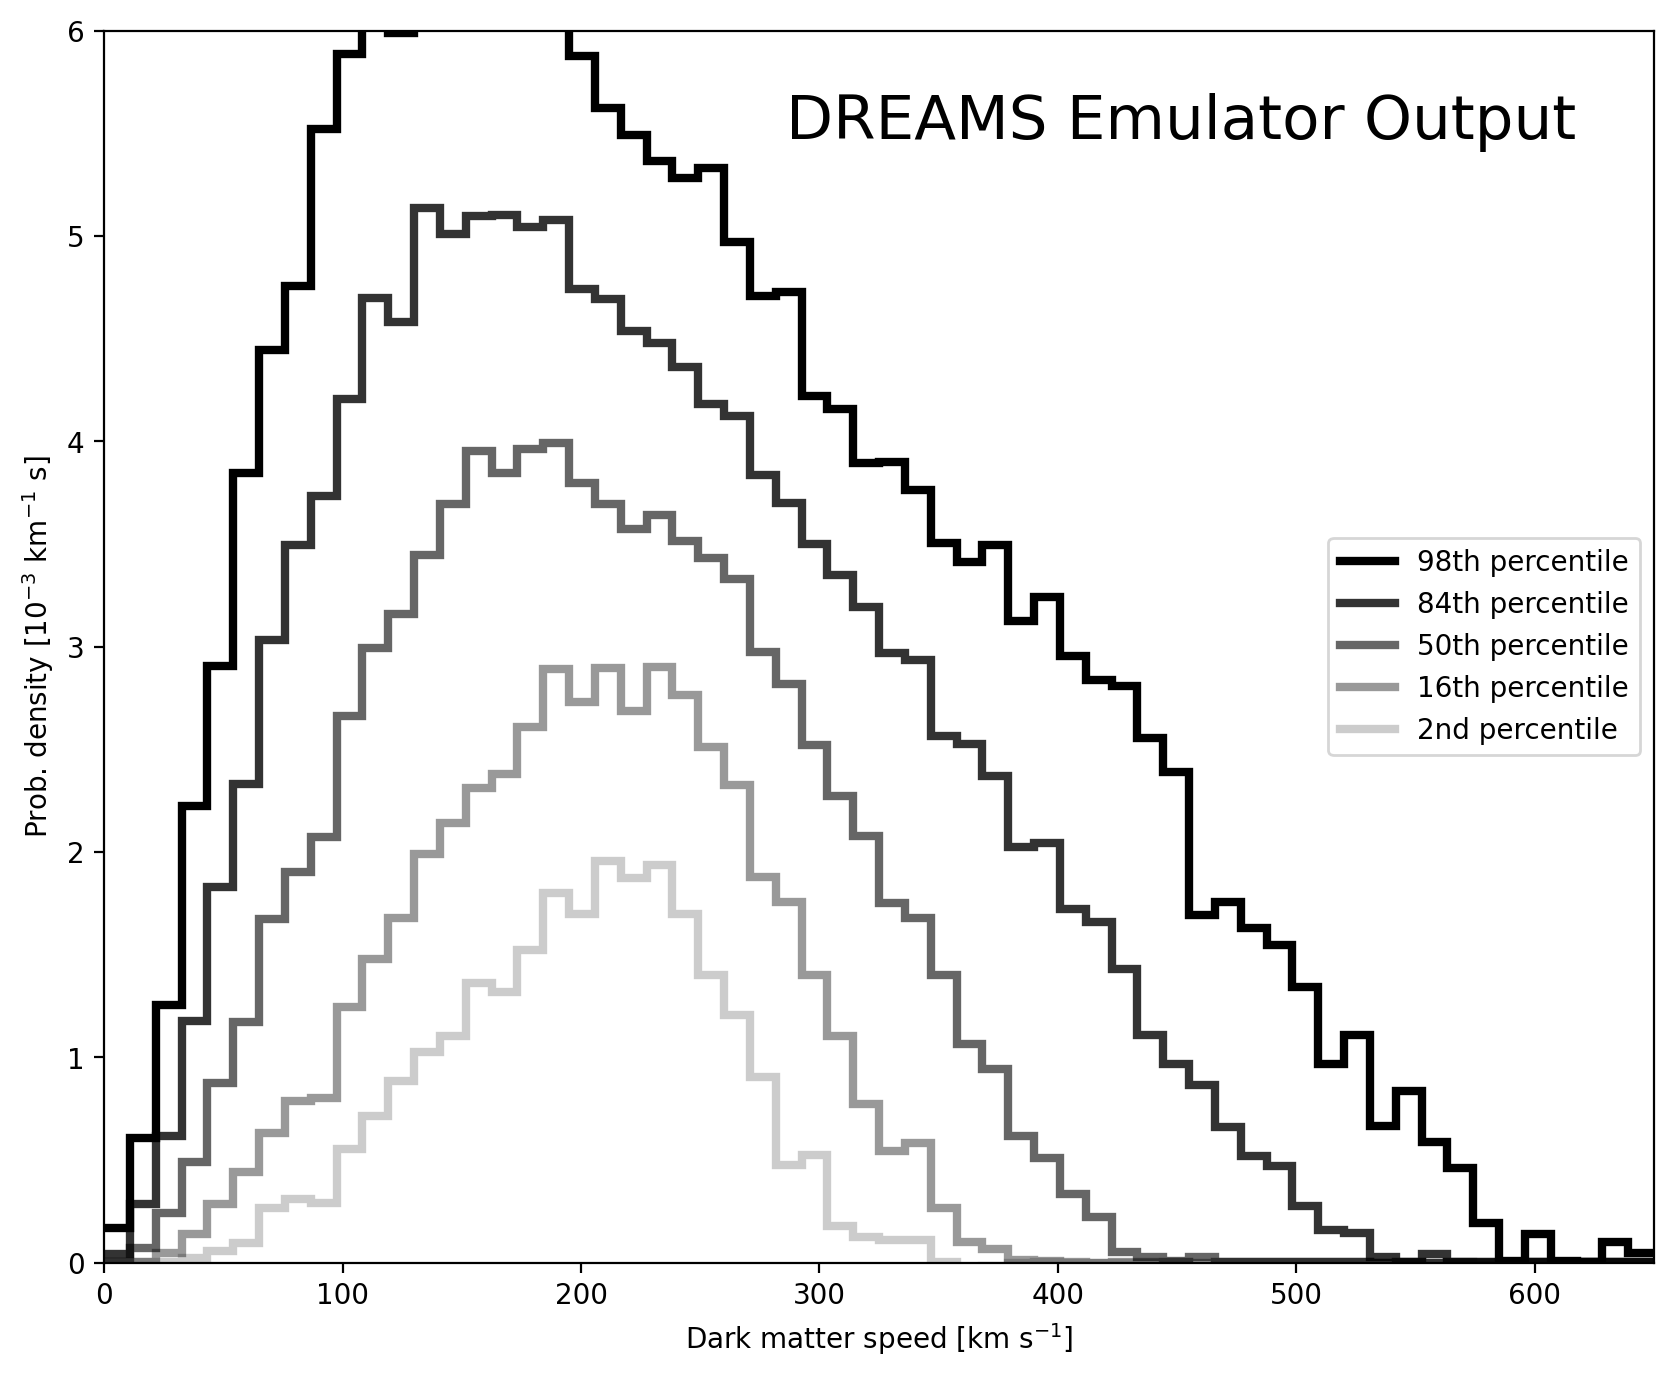

In [73]:
new_samples = em_hists
new_samples1 = new_samples[:,3:]#/For histogram remove the stellar mass, mlsr, and rm.
new_samples1 = new_samples1/(np.sum(new_samples1*binpos[1],axis=1)[:,None])#normalize histograms to 1 

hists,mins,two,sixteen,eightyfour,ninetyeight,maxs = histogram_averaging(new_samples1)

frq,edges = hists,binpos
fig,ax=plt.subplots(dpi=200,figsize=(10,8))

ax.set_xlim(0,650)
ax.set_ylim(0,.006*1E3)
plt.stairs(ninetyeight*1E3,edges,color='xkcd:black',zorder=1000,linewidth=LINEWIDTH,alpha=1,baseline=None,label='98th percentile')
plt.stairs(eightyfour*1E3,edges,color='xkcd:black',zorder=1000,linewidth=LINEWIDTH,alpha=.8,baseline=None,label='84th percentile')
plt.stairs(frq*1E3,edges,color='xkcd:black',zorder=1000,linewidth=LINEWIDTH,alpha=.6,baseline=None,label='50th percentile')#'M8kpc and Rm Binned Galaxies')
plt.stairs(sixteen*1E3,edges,color='xkcd:black',zorder=1000,linewidth=LINEWIDTH,alpha=.4,baseline=None,label='16th percentile')
plt.stairs(two*1E3,edges,color='xkcd:black',zorder=1000,linewidth=LINEWIDTH,alpha=.2,baseline=None,label='2nd percentile')
plt.text(0.95, 0.95, 'DREAMS Emulator Output', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top',fontsize=22)
plt.legend()

plt.xlabel('Dark matter speed [km s$^{-1}$]')
plt.ylabel('Prob. density [$10^{-3}$ km$^{-1}$ s]')

plt.show()

# The previous results varied over baryonic physics. We can now fix to the TNG fiducial values:

In [75]:
#RUN EMULATOR
def norm_flows_sample(model,new_norm_dict,num_samples):

    pl.seed_everything(1234)
    n_samples = num_samples  # number of samples to generate
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

#FIXING BARYONIC PHYSICS
    
    halo_range = np.random.uniform(11.6,12.2,size=(n_samples,1))


    context = np.zeros((n_samples,4))
    for i in range((n_samples)):
        context[i,:] = np.array([np.log10(3.6),np.log10(7.4),np.log10(.1),halo_range[i][0]])

    # normalized and convert to tensor
    context_norm = (context - new_norm_dict['cond_mean']) / new_norm_dict['cond_std']
    context_norm = torch.tensor(context_norm, dtype=torch.float32)
    context_norm = context_norm.to(model.device)

    with torch.no_grad():
        flow_context = model(context_norm)
        samples = model.flow(flow_context).sample()
        samples = samples.cpu().numpy()

    # rescale the samples to the original scale
    samples = samples * new_norm_dict['target_std'] + new_norm_dict['target_mean']

    return samples

In [76]:
#number of galaxies to sample
num_samps = 600

#sample
em_hists = norm_flows_sample(model_1,new_norm_dict_1,num_samps)

[rank: 0] Seed set to 1234


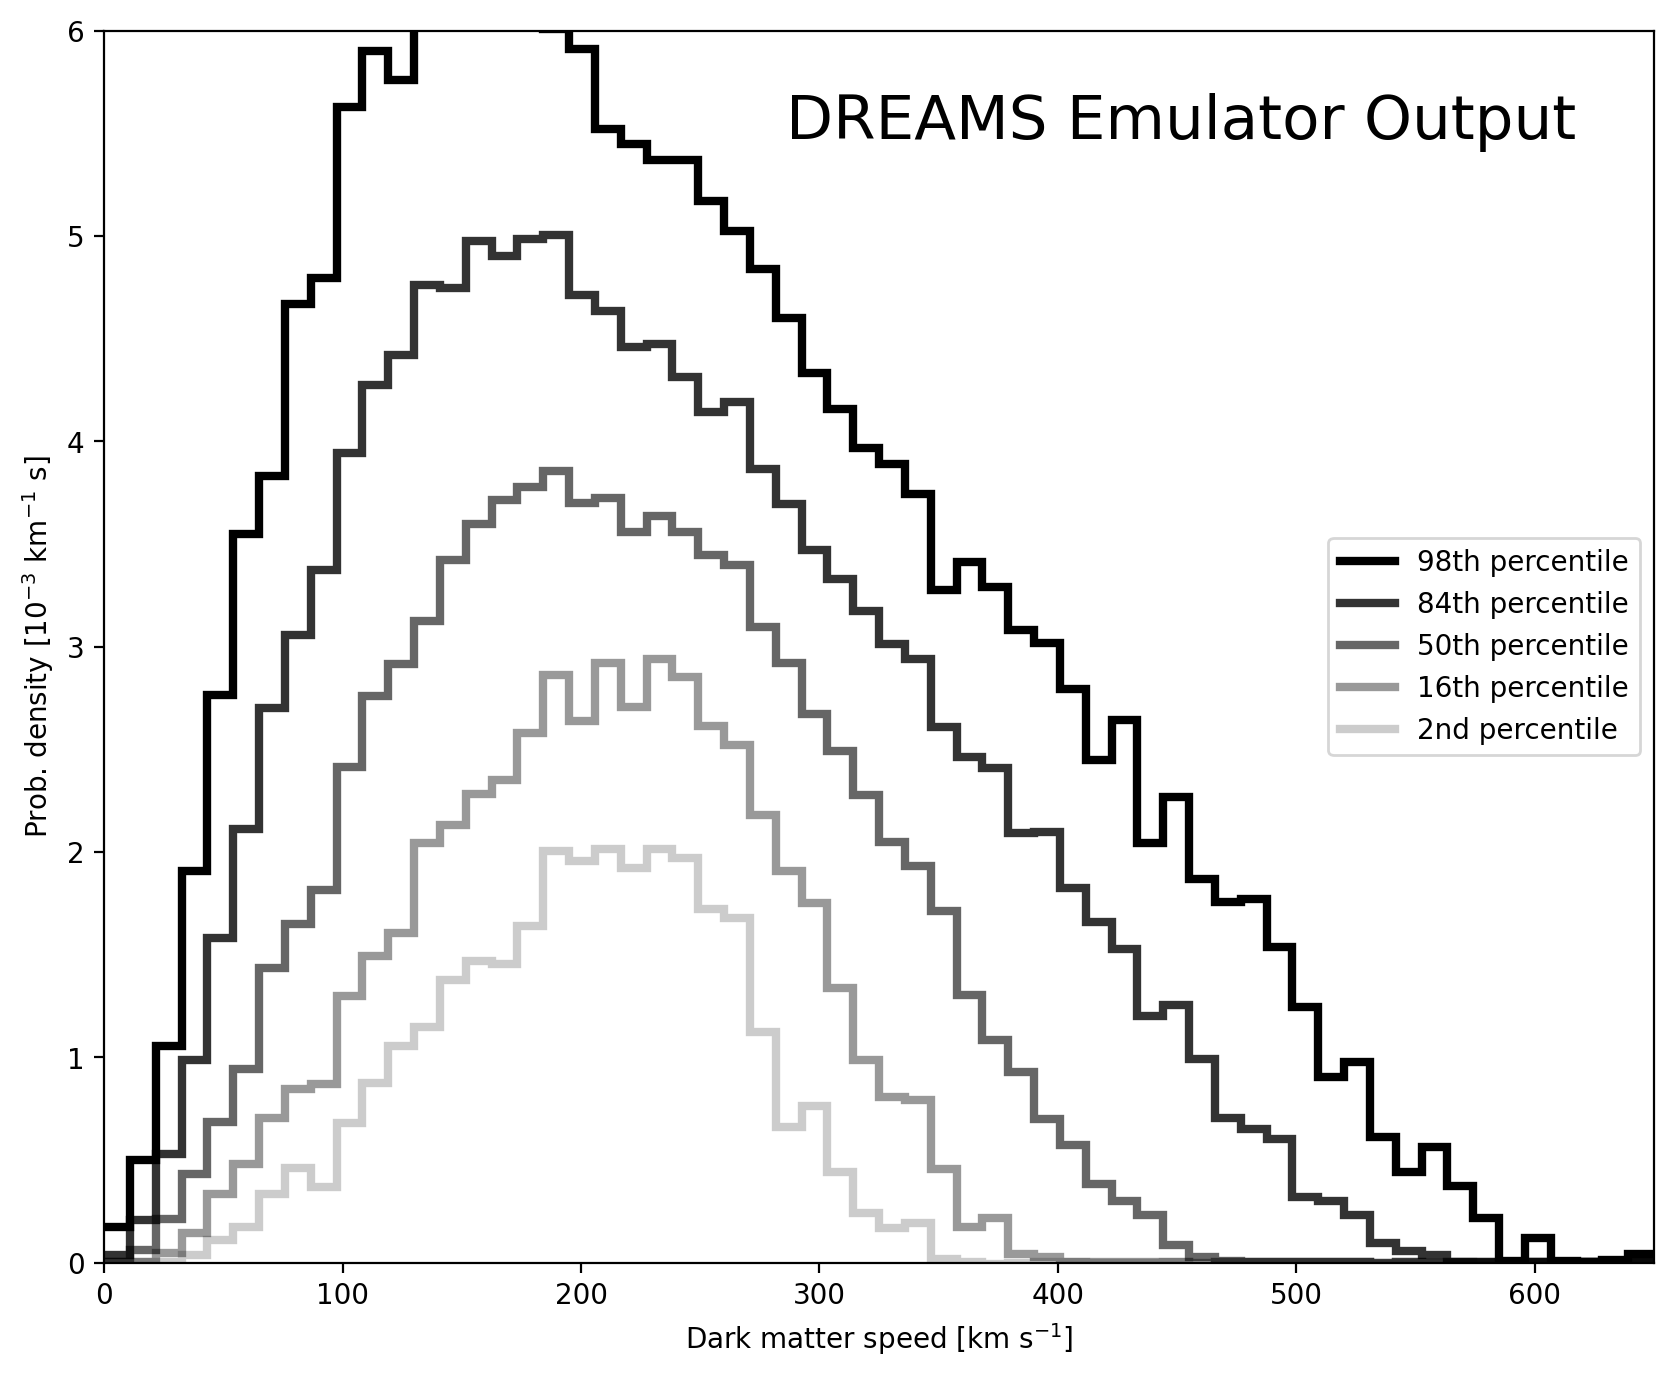

In [77]:
new_samples = em_hists
new_samples1 = new_samples[:,3:]#/For histogram remove the stellar mass, mlsr, and rm.
new_samples1 = new_samples1/(np.sum(new_samples1*binpos[1],axis=1)[:,None])#normalize histograms to 1 

hists,mins,two,sixteen,eightyfour,ninetyeight,maxs = histogram_averaging(new_samples1)

frq,edges = hists,binpos
fig,ax=plt.subplots(dpi=200,figsize=(10,8))

ax.set_xlim(0,650)
ax.set_ylim(0,.006*1E3)
plt.stairs(ninetyeight*1E3,edges,color='xkcd:black',zorder=1000,linewidth=LINEWIDTH,alpha=1,baseline=None,label='98th percentile')
plt.stairs(eightyfour*1E3,edges,color='xkcd:black',zorder=1000,linewidth=LINEWIDTH,alpha=.8,baseline=None,label='84th percentile')
plt.stairs(frq*1E3,edges,color='xkcd:black',zorder=1000,linewidth=LINEWIDTH,alpha=.6,baseline=None,label='50th percentile')#'M8kpc and Rm Binned Galaxies')
plt.stairs(sixteen*1E3,edges,color='xkcd:black',zorder=1000,linewidth=LINEWIDTH,alpha=.4,baseline=None,label='16th percentile')
plt.stairs(two*1E3,edges,color='xkcd:black',zorder=1000,linewidth=LINEWIDTH,alpha=.2,baseline=None,label='2nd percentile')
plt.text(0.95, 0.95, 'DREAMS Emulator Output', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top',fontsize=22)
plt.legend()

plt.xlabel('Dark matter speed [km s$^{-1}$]')
plt.ylabel('Prob. density [$10^{-3}$ km$^{-1}$ s]')

plt.show()